[여기 정리 중](#not_yet)

# 1.필요한 파일 불러오기 및 정리

In [508]:
from scipy.stats import pearsonr
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error




[Jupyter Notebook](https://github.com/georgezoto/recommender-systems-in-python/blob/master/Implementing%20your%20own%20recommender%20systems%20in%20Python%20by%20Agnes%20Johannsdottir/Implementing%20your%20own%20recommender%20systems%20in%20Python.ipynb)

[YoutubeLink](https://www.youtube.com/watch?v=R64Lh1Qwl_0)

[Month 2 Part I - UserUserCF](https://github.com/caiomiyashiro/RecommenderSystemsNotebooks/blob/master/Month%202%20Part%20I%20-%20User%20User%20Collaborative%20Filtering.ipynb)

In [521]:
raw = pd.read_csv('C:/Users/Hanna Kim/Desktop/drama_recommendation/reviews_to_top_40.csv', index_col = 0)
raw = raw.iloc[:, :3]
raw.columns = ['title', 'user', 'rating']
raw.sample(3)

,title,user,rating
14776,One Smile is Very Alluring,Yo0osammy,10.0
20119,The Heirs,Shaza,9.0
19758,The Producers,biniBningPunkista,8.0


## 1.1 title_df, user_df 만들기
user는 1~1000
title은 1000~10000<br>
**하고 싶었는데 이렇게 하면 안될것가탕...**

df는 id로만 정리된 데이터<br>
raw는 제목 글자까지 남은 데이터

In [523]:
user_df = pd.DataFrame(list(raw.user.unique()), columns = ['user'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(raw.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

raw = raw.merge(user_df, how = 'left' )
raw = raw.merge(title_df, how = 'left' )

df = raw[['usr_id', 'ttl_id', 'rating']]
raw = raw[['usr_id','user', 'ttl_id','title', 'rating']]

In [524]:
df.sample(3)

,usr_id,ttl_id,rating
13414,554,835,7.5
12177,1386,1421,8.0
21899,83,1610,8.5


## 1.2 pivot_df 만들기
user가 행, title이 id

In [526]:
pivot_df = df.pivot_table('rating', index = 'usr_id', columns = 'ttl_id')
pivot_df.sample(4)

ttl_id,1,2,3,4,5,6,7,8,9,10,...,4431,4432,4433,4434,4435,4436,4437,4438,4439,4440
usr_id,,,,,,,,,,,,,,,,,,,,,
547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. EDA

In [529]:
print(f"데이터의 크기는                      : {df.shape}")
print(f"데이터에 포함된 유저의 수는          : {len(user_df)}")
print(f"데이터에 포함된 드라마/영화의 수는   : {len(title_df)}")

데이터의 크기는                      : (29467, 3)
데이터에 포함된 유저의 수는          : 1964
데이터에 포함된 드라마/영화의 수는   : 4440


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


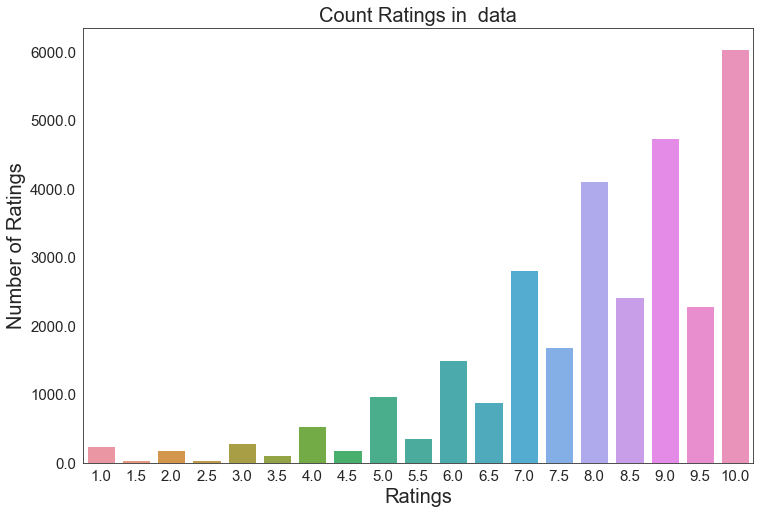

In [530]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in  data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [ ]:
def return_best_n(statistics, n):
    # statistics: array of size review.shape[1] containing one statistic calculated from the dataset
    # n: number of indices to be returned
    # returns: array of size *n* containing the indices of the best scored statistics
    statistics = pd.DataFrame({'statistic':statistics})
    return statistics.sort_values('statistic', ascending = False).iloc[:n]

### Mean rating

In [537]:
means = pivot_df.iloc[:,2:].apply(np.mean)
return_best_n(means,3)

,statistic
ttl_id,
2214,10.0
4106,10.0
841,10.0


In [534]:
df.groupby('ttl_id')['rating'].mean().sort_values(ascending=False).head()

ttl_id
1       10.0
3804    10.0
1494    10.0
3736    10.0
3740    10.0
Name: rating, dtype: float64

아마 평가한 유저가 별로 없어서 높은 점수 평균이 나왔을 것

### Rating count

In [536]:
count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(~np.isnan(col)))

# return_best_n(count,10).index 를 구하면 제목만 뽑을 수 있음
return_best_n(count,3)

,statistic
ttl_id,
935,300
446,274
3182,221


In [538]:
df.groupby('ttl_id')['rating'].count().sort_values(ascending=False).head()

ttl_id
2464    377
935     330
446     311
224     298
505     267
Name: rating, dtype: int64

### % of Good Ratings

점수 scale : (1,10)<br>
**8 이상인 평점의 비율**

In [541]:
good_count = pivot_df.iloc[:,2:].apply(lambda col : np.sum(col >=  8)/np.sum(~np.isnan(col)))
return_best_n(good_count,3)

,statistic
ttl_id,
3,1.0
1881,1.0
1918,1.0


리뷰가 하나밖에 없는 책이면, 리뷰 수 대비 좋은 리뷰 값이 높을 수 밖에 없음<br>
리뷰 숫자가 충분한 경우에만 확인하기!

In [550]:
means = pd.DataFrame(means, columns = ['rating_avg'])
count = pd.DataFrame(count, columns = ['no_of_ratings'])
rating_pct = pd.DataFrame(good_count, columns = ['over_8_ratio'])

ratings = pd.merge(left=means, right=count, how='left',left_index=True,right_index=True)

ratings = ratings.merge(rating_pct, how='left',left_index=True,right_index=True)

ratings.sample(3)

,rating_avg,no_of_ratings,over_8_ratio
ttl_id,,,
2875,7.0,1,0.0
4385,9.0,1,1.0
2172,6.0,2,0.0


In [551]:
ratings.query('no_of_ratings > 100').sort_values(by='over_8_ratio', ascending=False).head(3)

,rating_avg,no_of_ratings,over_8_ratio
ttl_id,,,
446,9.374696,274,0.930657
1383,9.076023,171,0.888889
1679,8.951327,113,0.867257


<AxesSubplot:>

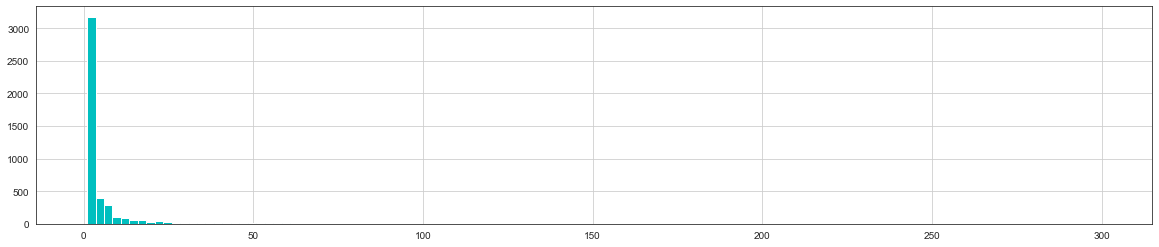

In [543]:
plt.figure(figsize = (20,4))
ratings['no_of_ratings'].hist(bins=120,color='c')

<AxesSubplot:>

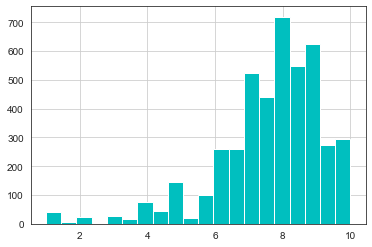

In [558]:
# plt.figure(figsize = (20,4))
ratings['rating_avg'].hist(bins=20,color='c')

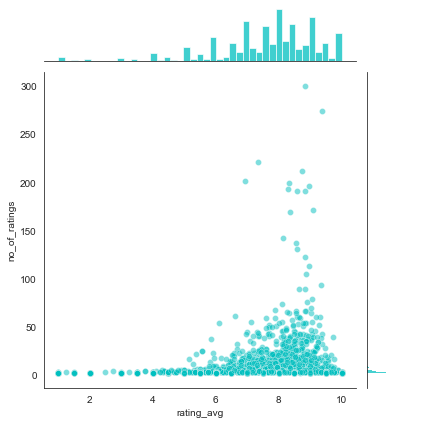

In [552]:
sns.jointplot(x='rating_avg', y='no_of_ratings', data= ratings, alpha = 0.5, color='c')

In [559]:
ratings['no_of_ratings'].describe()

count    4438.000000
mean        5.379450
std        14.493002
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       300.000000
Name: no_of_ratings, dtype: float64

In [561]:
ratings['no_of_ratings'].quantile(np.arange(0, 0.70, 0.1))

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    2.0
0.6    2.0
Name: no_of_ratings, dtype: float64

In [565]:
ratings_min_4 = ratings.query('no_of_ratings >= 4')
print(ratings_min_4.shape)

(1260, 3)


In [566]:
ratings_min_4.head(3)

,rating_avg,no_of_ratings,over_8_ratio
ttl_id,,,
8,4.625000,4,0.000000
9,8.916667,6,1.000000
12,8.705882,17,0.941176


# 3. Split Data

In [578]:
new_df = df[df.index.isin(ratings_min_4.index)]
print(f"dataset changes from {df.shape}")
print(f"to {new_df.shape}")


dataset changes from (29467, 3)
to (1260, 3)


In [580]:
print(f"unique number of title before  : {len(list(df.ttl_id.unique()))}")

print(f"unique number of title after : {len(list(new_df.ttl_id.unique()))}")

unique number of title before  : 4440
unique number of title after : 850


이러면 usr_id, ttl_id 다시줘야함

In [591]:
new_df = new_df.merge(user_df, how='left').merge(title_df, how='left')

In [593]:
new_df= new_df.iloc[:, 2:]
new_df.head()

,rating,user,title
0,10.0,KarolineAskeroed,Remember: War of the Son
1,9.0,WonByungHoon,Kang Koo's Story
2,7.0,PHope,Kingyo Club
3,10.0,asiandramafan,Someone Like You
4,8.0,WonByungHoon,Too Beautiful to Lie


In [594]:
user_df = pd.DataFrame(list(new_df.user.unique()), columns = ['user'])
user_df['usr_id'] = random.sample(range(1,len(user_df)+1), len(user_df))

title_df = pd.DataFrame(list(new_df.title.unique()), columns = ['title'])
title_df['ttl_id'] = random.sample(range(1,len(title_df)+1), len(title_df))

new_df = new_df.merge(user_df, how = 'left' )
new_df = new_df.merge(title_df, how = 'left' )

new_df = new_df[['usr_id', 'ttl_id', 'rating']]

In [599]:
new_df.sample(3)

,usr_id,ttl_id,rating
148,7,218,10.0
70,58,16,9.0
1009,47,406,7.0


In [600]:
new_df = new_df.sample(frac=1)
split_value = int(len(new_df) * 0.80)
train_data = new_df[:split_value]
test_data = new_df[split_value:]


In [652]:
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(df_pra, test_size=0.2)

## 3.2 Create User-Item Matrix

#### 정석?

In [601]:
#이때 n_user, n_items는 전체 유저! 테스ㅡㅌ 말고

n_users = new_df.usr_id.unique().shape[0]
n_items = new_df.ttl_id.unique().shape[0]

In [603]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [605]:
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(106, 850)
(106, 850)


In [606]:
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### 야매

In [608]:
moviemat = train_data.pivot_table(index='usr_id', columns = 'ttl_id', values = 'rating')
moviemat.head()

ttl_id,1,2,3,4,5,6,7,9,10,12,...,841,842,843,844,845,846,847,848,849,850
usr_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Similarity to Prediction

## 4.1 Cosine Similarity (1)

### similarity
You can use the pairwise_distances function from sklearn to calculate the cosine similarity.

Note, the output will range from 0 (no distance, identical vectors) to 1 (significant distance, different vectors) since the ratings are all positive.

In [610]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [611]:
print(user_similarity.shape)
print(item_similarity.shape)

(106, 106)
(850, 850)


In [612]:
user_similarity

array([[0.        , 0.93732825, 1.        , ..., 1.        , 1.        ,
        0.93097269],
       [0.93732825, 0.        , 0.88842431, ..., 1.        , 0.84358762,
        0.89801757],
       [1.        , 0.88842431, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.84358762, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.93097269, 0.89801757, 1.        , ..., 1.        , 1.        ,
        0.        ]])

### prediction

user similarity를 사용하려면 normalization필요<br>
유저가 점수 매기는 수준이 각기 다를 수 있으므로

In [694]:

def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [695]:

user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

In [697]:
print(user_prediction.shape)
user_prediction

(106, 850)


array([[ 0.13085187,  0.13085187,  0.07180644, ...,  0.20311749,
         0.14069277,  0.13085187],
       [ 0.12316567,  0.12518932,  0.06368147, ...,  0.19455182,
         0.13544062,  0.12316567],
       [ 0.06331323,  0.06331323,  0.00591623, ...,  0.12881273,
         0.07287939,  0.06331323],
       ...,
       [ 0.0013705 ,  0.0013705 , -0.05607278, ...,  0.0731746 ,
         0.00148966,  0.0013705 ],
       [ 0.00192493,  0.00192493, -0.05591589, ...,  0.07422597,
         0.01156507,  0.00192493],
       [ 0.02862179,  0.03001833, -0.03045837, ...,  0.10105792,
         0.04009777,  0.02862179]])

In [698]:
print(item_prediction.shape)
item_prediction

(106, 850)


array([[0.18414661, 0.14884369, 0.14775414, ..., 0.14997765, 0.15767121,
        0.18414661],
       [0.16813218, 0.14050844, 0.13947991, ..., 0.13691654, 0.14884162,
        0.16813218],
       [0.10091234, 0.08156634, 0.08096927, ..., 0.07664448, 0.08640382,
        0.10091234],
       ...,
       [0.02357077, 0.01905199, 0.01891253, ..., 0.01926745, 0.0129115 ,
        0.02357077],
       [0.02430735, 0.01964737, 0.01950355, ..., 0.01986956, 0.0208126 ,
        0.02430735],
       [0.0539442 , 0.04643923, 0.04609929, ..., 0.04455954, 0.04919342,
        0.0539442 ]])


### Evaluate the accuracy with RMSE
[Evaluating Recommendation Systems.pdf](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/EvaluationMetrics.TR_.pdf)

In [699]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [700]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(y_pred = prediction, y_true= ground_truth))

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return (mean_absolute_error(y_pred = prediction, y_true= ground_truth))

In [701]:
print('User-based CF RMSE:', rmse(user_prediction, test_data_matrix))
print('Item-based CF RMSE:', rmse(item_prediction, test_data_matrix))

print('User-based CF MAE:', mae(user_prediction, test_data_matrix))
print('Item-based CF MAE:', mae(item_prediction, test_data_matrix))

User-based CF RMSE: 7.5642095920634045
Item-based CF RMSE: 7.653671088702228
User-based CF MAE: 7.291275463567927
Item-based CF MAE: 7.3864703447583



<div class="alert alert-warning">
specific user/drama에대한 예측치 를 뽑아내는법?
</div>

## 4.2 Cosine Similarity (2)

In [626]:
from scipy.sparse import csr_matrix

In [627]:
train_item_pivot = train_data.pivot_table(index = 'ttl_id', columns = 'usr_id',values =  'rating').fillna(0)
train_item_matrix = csr_matrix(train_item_pivot)

In [628]:
train_item_matrix

<719x97 sparse matrix of type '<class 'numpy.float64'>'
	with 993 stored elements in Compressed Sparse Row format>

In [629]:
from sklearn.neighbors import NearestNeighbors


In [630]:
model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute')
model_knn.fit(train_item_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Prediction 여기 아직 정리 못함<a class="anchor" id="not_yet"></a>

In [704]:
query_index = np.random.choice(train_item_pivot.shape[0])

distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {train_item_pivot.index[query_index]}")
    else:
        print(f'{i} : {train_item_pivot.index[indices.flatten()[i]]}, with distance of :{distances.flatten()[i]}')


Recommendations for 776
1 : 834, with distance of :0.0
2 : 776, with distance of :0.0
3 : 479, with distance of :0.0
4 : 474, with distance of :0.0
5 : 604, with distance of :0.0



<div class="alert alert-warning">
query_index = 159로 돌리면 다 0으로 나옴
</div>


**왜지?**
query_index = ttl중 random한 번호

query_index = 159?

In [707]:

# train_item_pivot

# train_item_pivot.index[(train_item_pivot.iloc[159])]

# train_item_pivot.index[query_index] = 159

# train_item_pivot.iloc[159]



query_index = 159는 아닌듯

In [708]:
distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"Recommendations for {train_item_pivot.index[query_index]}")
    else:
        print(f'{i} : {train_item_pivot.index[indices.flatten()[i]]}, with distance of :{distances.flatten()[i]}')

Recommendations for 776
1 : 834, with distance of :0.0
2 : 776, with distance of :0.0
3 : 479, with distance of :0.0
4 : 474, with distance of :0.0
5 : 604, with distance of :0.0


In [710]:
#일단 포기하고
#### 제목 나오게하기!

title_df.index = title_df['ttl_id']
title_df = title_df[['title']]
title_df.sample(2)

,title
ttl_id,
545,With You
41,Princess Agents


In [711]:

query_index = np.random.choice(train_item_pivot.shape[0])

distances, indices = model_knn.kneighbors(train_item_pivot.iloc[query_index, :].values.reshape(1,-1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    seen = train_item_pivot.index[query_index]
    unseen = train_item_pivot.index[indices.flatten()[i]]
    distance = distances.flatten()[i]
    if i == 0:
        print(f"Recommendations for {title_df.iloc[seen][0]}")
    else:
        print(f'{i} : {title_df.iloc[unseen][0]}, with distance of :{distance}')





Recommendations for Boys Over Flowers
1 : Attack on Titan, with distance of :0.0
2 : Mermaid Prince, with distance of :0.0
3 : The Chinese Widow, with distance of :0.0
4 : Wednesday 3:30 PM, with distance of :0.0
5 : A Man and A Woman, with distance of :0.0


## 4.3 Correlation Similarity - 야매

In [634]:
title_df[title_df['ttl_id'] == 5]

,title,ttl_id
58,Oh My Venus,5


Oh My Venus에 대한 correlation

In [635]:
omv_user_ratings = moviemat[5]
omv_user_ratings

usr_id
1      NaN
2      9.5
3      NaN
4      NaN
5      NaN
      ... 
101    9.5
102    8.0
104    NaN
105    NaN
106    NaN
Name: 5, Length: 97, dtype: float64

In [636]:
similar_to_omv = moviemat.corrwith(omv_user_ratings)

C:\Users\Hanna Kim\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Hanna Kim\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [639]:
corr_omv = pd.DataFrame(similar_to_omv, columns = ['Correlation'])
corr_omv.dropna(inplace=True)
corr_omv.sort_values('Correlation', ascending=False).head()

,Correlation
ttl_id,
5,1.000000
415,1.000000
511,1.000000
146,0.885892
670,-0.500000


In [642]:
# corr_healer = corr_healer.join(ratings['num_of_ratings'])
corr_omv = corr_omv.merge(ratings['no_of_ratings'], left_index=True, right_index=True)

In [649]:
corr_omv[corr_omv['no_of_ratings']>3].sort_values('Correlation', ascending=False).head()

,Correlation,no_of_ratings
ttl_id,,
415,1.000000,5
146,0.885892,4
670,-0.500000,20
738,-1.000000,4


In [651]:
corr_omv_highest = corr_omv[corr_omv['no_of_ratings']>3].sort_values('Correlation', ascending=False)
# 자기 자신 제외하고 돌려줘야함
corr_omv_highest[~(corr_omv_highest.index == 5)].head(3)

,Correlation,no_of_ratings
ttl_id,,
415,1.000000,5
146,0.885892,4
670,-0.500000,20


## 4.4 Pearson Corr 활용

user-user corr 구하기

In [684]:
new_df.sample()

,usr_id,ttl_id,rating
579,85,93,6.0


In [685]:
df_corr = new_df.pivot_table(index = 'ttl_id', columns = 'usr_id', values = 'rating').corr(method = 'pearson')

In [686]:
df_corr.count()

usr_id
1       4
2      14
3       3
4       0
5       3
       ..
102     3
103     0
104     2
105     1
106     8
Length: 106, dtype: int64

In [687]:
def findKNearestUsers(userCorrCol, k = 5):
    return userCorrCol[userCorrCol.index != userCorrCol.name].nlargest(n = k).index.tolist()

kNeighboors = df_corr.apply(lambda col: findKNearestUsers(col))
kNeighboors

usr_id
1              [42, 43, 52]
2      [30, 58, 60, 67, 74]
3                  [85, 69]
4                        []
5                  [85, 92]
               ...         
102                [30, 92]
103                      []
104                    [85]
105                      []
106     [42, 2, 14, 30, 82]
Length: 106, dtype: object

In [692]:
new_df.usr_id.nunique()

106

In [693]:
def calculatePredictionsUser(kNeighboors, user_correlations, df):
    
    def calculatePredictionsUserMovie(kNeighboors, user_correlations, movieRowRatings): 
        hasRatedMovie = ~np.isnan(movieRowRatings)
        if(np.sum(hasRatedMovie) != 0): # only return value if there was at least one neighboor who also rated that movie
            return np.dot(movieRowRatings.loc[hasRatedMovie], user_correlations.loc[hasRatedMovie])/np.sum(user_correlations[hasRatedMovie])
        else:
            return np.nan
        
    # looking at one user, apply function for each row = movie and predict rating for that movie
    return df.apply(lambda movieRow: calculatePredictionsUserMovie(kNeighboors, user_correlations, movieRow[kNeighboors]), axis=1)


In [500]:
%%time
####### Starting process point
# call function sending user's neighboors, neighboors similarity and movie ratings df     
moviePredictions = item_user.apply(lambda userRatings: calculatePredictionsUser(kNeighboors[userRatings.name], 
                                                      df_corr[userRatings.name][kNeighboors[userRatings.name]],
                                                      item_user))


C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Hanna Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [503]:
moviePredictions

rvr_id,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
ttl_id,,,,,,,,,,,,,,,,,,,,,
1000,10.0,NaN,NaN,NaN,9.0,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,9.5
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [505]:
print("Taking a look at an example user's predictions and 10 best movies recommended by highest score")
moviePredictions[100].sort_values(ascending=False).head(10)

Taking a look at an example user's predictions and 10 best movies recommended by highest score


ttl_id
3528    10.0
7436    10.0
6429    10.0
6321    10.0
5303    10.0
1461    10.0
4711    10.0
8874    10.0
2577    10.0
8907    10.0
Name: 100, dtype: float64

# 또 다른 세계..`

In [ ]:
# 원래 코드는 ㄹㅇ 단순하게 그냥 80%로 ㅗ자르는 건데 유저 수로 80, 20 퍼센트 자르는게 나을듯!

# split_value = int(len(df) * 0.80)
# train_data = df[:split_value]
# test_data = df[split_value:]

In [95]:
# rvr_list = df.rvr_id.unique()
# split_value = round(len(list(rvr_list))*0.80)

In [97]:
# train_list = rvr_list[:split_value]
# test_list = rvr_list[split_value:]

In [101]:
# train_data = df[df['rvr_id'].isin(train_list)]
# test_data = df[df['rvr_id'].isin(test_list)]

일단 train 저렇게 나누는건 확실하지 않음

In [712]:
train_data

,usr_id,ttl_id,rating
1161,84,132,9.5
1123,6,819,5.5
176,21,370,6.5
361,58,712,7.0
18,52,196,8.0
...,...,...,...
142,2,245,9.5
621,92,620,4.0
190,18,344,9.0
603,43,657,2.0


In [715]:
# create user*item matrix
def get_user_item_sparse_matrix(new_df):
    sparse_data = sparse.csr_matrix((new_df.rating, (new_df.usr_id, new_df.ttl_id)))
    return sparse_data

In [716]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

test_sparse_data = get_user_item_sparse_matrix(test_data)

In [717]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))


Global Average Rating: 7.775931520644511


### Similarity Matrix

In [718]:

title_df.sample(3)

,title
ttl_id,
678,Orange
157,Nibiiro no Hako no Naka de
738,Introverted Boss


In [719]:
# 나는 인덱스 0에 movie title이 들어가잇으니까 0!
def compute_movie_similarity_count(sparse_matrix, title_df, ttl_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = title_df.loc[ttl_id][0], similarity[ttl_id].count_nonzero()
    return no_of_similar_movies

In [725]:
title_df.loc[738][0]

'Introverted Boss'

In [726]:
similar_movies = compute_movie_similarity_count(train_sparse_data, title_df, 738)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Introverted Boss', 203)


In [727]:
pd.DataFrame(similarity[738])

,0
0,


In [728]:
similarity[738]

<1x9998 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [124]:
similarity[1662] > 0.5

<1x9998 sparse matrix of type '<class 'numpy.bool_'>'
	with 1 stored elements in Compressed Sparse Row format>

[handling sparse matrix](https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/)

In [135]:
(similarity[1662] > 0.3)
(similarity[1662] > 0.3).indices
title_df.loc[((similarity[1662] > 0.3).indices)]

,title
ttl_id,
122,Sapai Import
237,Clean With Passion For Now
1435,You are My Destiny
1662,Before We Get Married
3371,The Secret Life of My Secretary
3372,The Legends
4354,Devilish Joy
4616,Search: WWW
5410,My Husband in Law


In [186]:
def compute_user_similarity(sparse_matrix):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(9998*9998).reshape(9998,9998)
    
    for row in rows:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

similar_user_matrix = compute_user_similarity(train_sparse_data)

In [501]:
similar_user_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.21398485, 0.21829912,
        1.        ]])

In [213]:
def say_two_words(name):
    return name, name+"3"

In [214]:
k, b = say_two_words("Hanna")

In [217]:
b

'Hanna3'

In [209]:
sim.argsort?

In [204]:
similar_indices

array([6012,  436,  498, 9870, 1725, 6244, 7784, 9539, 7549,   20],
      dtype=int64)

In [198]:
type(similar_user_matrix)

numpy.ndarray

In [201]:
np.where(similar_user_matrix[1904] > 0.5)

(array([9997], dtype=int64),)

In [208]:
similar_user_matrix[436, 1904]

0.0

In [203]:
(similar_user_matrix[1904] > 0.5)

AttributeError: 'numpy.ndarray' object has no attribute 'indices'

In [196]:
similar_user_matrix[1904][similar_user_matrix[1904] > 0.5]

array([1.])

In [188]:
user_df

,reviewer,rvr_id
0,kingsqueen,1904
1,dragynfaerie,1352
2,PickyMcpickleton,5077
3,AnanyaS,20
4,wonhwa,2168
...,...,...
716,Carollama,6525
717,Aladdin,5750
718,DesperateDramaHunter,3675
719,rqueen,1219


In [282]:
a = pd.DataFrame({"name": ["Hanna", "Kate", "Sophie"]}, index = ["kim", "lee", "ju"])
a

,name
kim,Hanna
lee,Kate
ju,Sophie


In [289]:
a.loc['kim']

name    Hanna
Name: kim, dtype: object

In [39]:
name_list = ["kim", "ju"]

In [41]:
a = a.drop(name_list)
a

,name
lee,Kate
